# 필요 라이브러리 import

In [1]:
from google.colab import drive
import zipfile
import os
import random
from IPython.display import Image as show_image
import matplotlib.pyplot as plt
import json
import glob
import numpy as np
import pandas as pd
from ast import literal_eval
from PIL import Image, ImageDraw
from tqdm import tqdm
import yaml
from collections import OrderedDict
import shutil
import torch

# 드라이브 마운트 후 압축 해제

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 파일 경로 설정
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Mini Project/Cat breeds detection/V_2/Cat Breeds Detection_v2.v1i.yolov11.zip'
extract_path = '/content/'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"압축 해제 완료: {zip_file_path} -> {extract_path}")
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {zip_file_path}")
except zipfile.BadZipFile:
    print(f"잘못된 zip 파일입니다: {zip_file_path}")
except Exception as e:
    print(f"압축 해제 중 오류 발생: {e}")

압축 해제 완료: /content/drive/MyDrive/Colab Notebooks/Mini Project/Cat breeds detection/V_2/Cat Breeds Detection_v2.v1i.yolov11.zip -> /content/


train 폴더의 이미지 개수: 1119


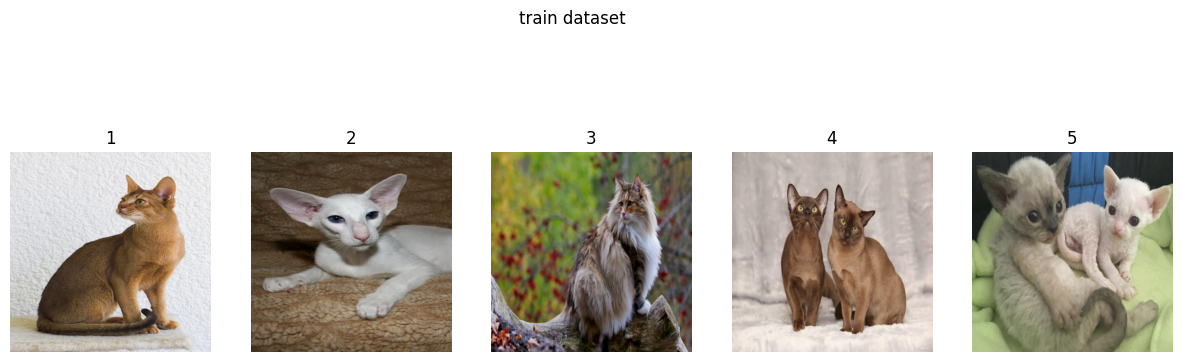

In [4]:
# 이미지 폴더 경로 설정
base_path = '/content/'
folders = ['train']

for folder in folders:
    image_folder = os.path.join(base_path, folder, 'images')
    if not os.path.exists(image_folder):
        print(f"폴더가 존재하지 않습니다: {image_folder}")
        continue

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    num_images = len(image_files)
    print(f"{folder} 폴더의 이미지 개수: {num_images}")

    # 랜덤으로 5개 이미지 선택 (중복 없이)
    selected_images = random.sample(image_files, min(5, num_images))

    # 폴더별 5장의 이미지 시각화 (이미지 이름 대신 번호 사용)
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(image_folder, image_file)
        try:
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(f"{i+1}")  # 이미지 번호 표시
            plt.axis('off')
        except Exception as e:
            print(f"이미지 로드 중 오류 발생: {e}, 파일: {img_path}")

    plt.suptitle(f"{folder} dataset")
    plt.show()

---

### 다운샘플링

In [5]:
from collections import defaultdict

def downsample_classes(label_dir, target_classes, target_count):
    # 클래스별 파일 인덱스 수집
    class_files = defaultdict(list)

    # 라벨 파일들을 순회하며 클래스별로 파일 수집
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            if label in target_classes:
                class_files[label].append(label_file)

    # 제거할 파일 선택
    files_to_remove = []
    for class_id in target_classes:
        if len(class_files[class_id]) > target_count:
            # 무작위로 파일 선택하여 유지할 개수만 남기기
            files_to_keep = random.sample(class_files[class_id], target_count)
            files_to_remove.extend([f for f in class_files[class_id] if f not in files_to_keep])

    # 선택된 파일들 제거
    for file_name in files_to_remove:
        # 라벨 파일 제거
        label_path = os.path.join(label_dir, file_name)
        if os.path.exists(label_path):
            os.remove(label_path)

        # 해당하는 이미지 파일도 제거
        image_file = file_name.replace('.txt', '.jpg')
        image_path = os.path.join('train/images', image_file)
        if os.path.exists(image_path):
            os.remove(image_path)

    return len(files_to_remove)

# 실행
target_classes = [7, 16, 19]
target_count = 45  # 각 클래스당 유지할 샘플 수
removed_count = downsample_classes('train/labels', target_classes, target_count)
print(f"제거된 파일 수: {removed_count}")

제거된 파일 수: 216


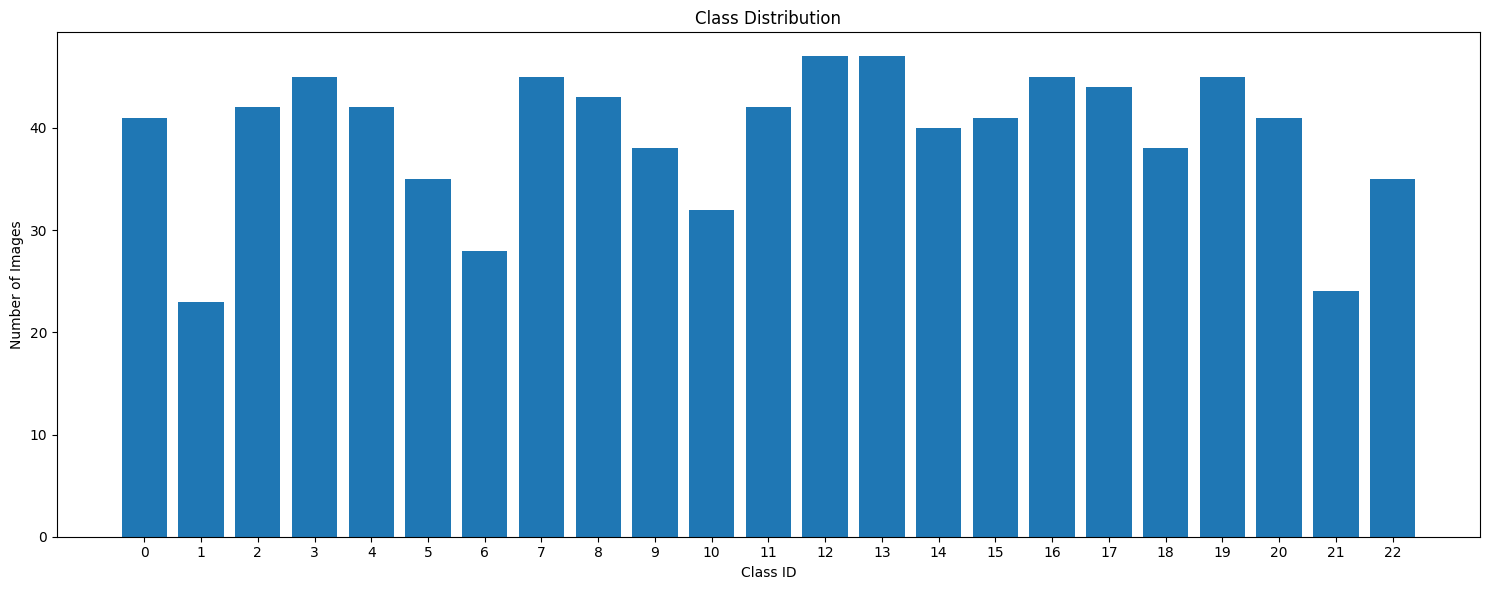

Class 5: 35 images
Class 2: 42 images
Class 8: 43 images
Class 16: 45 images
Class 18: 38 images
Class 14: 40 images
Class 11: 42 images
Class 7: 45 images
Class 19: 45 images
Class 20: 41 images
Class 13: 47 images
Class 12: 47 images
Class 22: 35 images
Class 1: 23 images
Class 17: 44 images
Class 21: 24 images
Class 10: 32 images
Class 9: 38 images
Class 3: 45 images
Class 0: 41 images
Class 15: 41 images
Class 4: 42 images
Class 6: 28 images


In [6]:
from collections import Counter

def visualize_class_distribution(label_dir):
    class_counts = Counter()

    # 라벨 파일들을 순회하며 클래스별 개수 계산
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    # 클래스 ID와 개수 추출
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    # 시각화
    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.xticks(classes)
    plt.tight_layout()
    plt.show()

    # 클래스별 개수 출력
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} images")

# 실행
visualize_class_distribution('train/labels')


### 업샘플링

In [7]:
def upsample_classes(label_dir, target_classes, target_count):
    # 클래스별 파일 인덱스 수집
    class_files = defaultdict(list)

    # 라벨 파일들을 순회하며 클래스별로 파일 수집
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            if label in target_classes:
                class_files[label].append(label_file)

    # 업샘플링 수행
    files_added = 0
    for class_id in target_classes:
        current_files = class_files[class_id]
        samples_needed = target_count - len(current_files)

        if samples_needed > 0:
            # 무작위로 파일 선택하여 복제
            for i in range(samples_needed):
                # 원본 파일 선택
                original_file = random.choice(current_files)

                # 새 파일명 생성
                new_label_file = f"{os.path.splitext(original_file)[0]}_up{i}.txt"
                new_image_file = f"{os.path.splitext(original_file)[0]}_up{i}.jpg"

                # 라벨 파일 복사
                shutil.copy2(
                    os.path.join(label_dir, original_file),
                    os.path.join(label_dir, new_label_file)
                )

                # 이미지 파일 복사
                original_image = original_file.replace('.txt', '.jpg')
                shutil.copy2(
                    os.path.join('train/images', original_image),
                    os.path.join('train/images', new_image_file)
                )

                files_added += 1

    return files_added

# 실행
target_classes = [1, 5, 6, 10, 21, 22]
target_count = 40  # 각 클래스당 목표 샘플 수
added_count = upsample_classes('train/labels', target_classes, target_count)
print(f"추가된 파일 수: {added_count}")


추가된 파일 수: 63


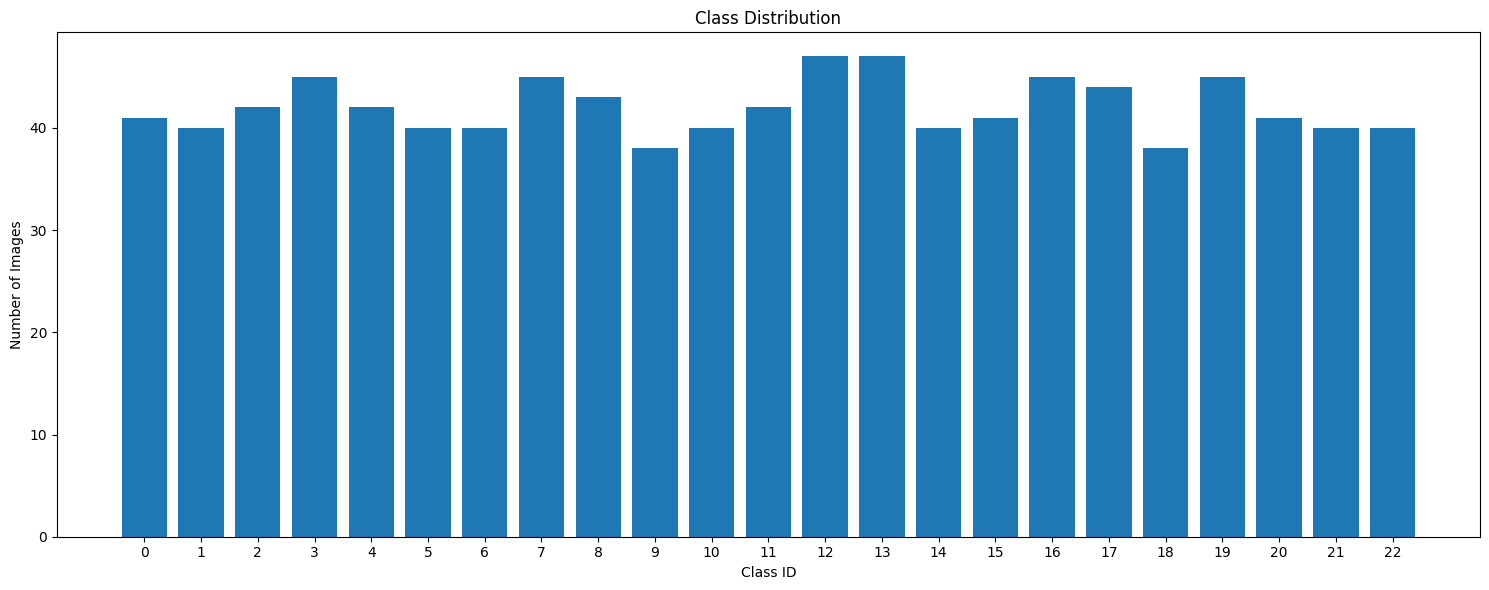

Class 5: 40 images
Class 6: 40 images
Class 2: 42 images
Class 8: 43 images
Class 16: 45 images
Class 18: 38 images
Class 14: 40 images
Class 11: 42 images
Class 7: 45 images
Class 19: 45 images
Class 20: 41 images
Class 13: 47 images
Class 12: 47 images
Class 22: 40 images
Class 1: 40 images
Class 17: 44 images
Class 21: 40 images
Class 10: 40 images
Class 9: 38 images
Class 3: 45 images
Class 0: 41 images
Class 15: 41 images
Class 4: 42 images


In [8]:
def visualize_class_distribution(label_dir):
    class_counts = Counter()

    # 라벨 파일들을 순회하며 클래스별 개수 계산
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    # 클래스 ID와 개수 추출
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    # 시각화
    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.xticks(classes)
    plt.tight_layout()
    plt.show()

    # 클래스별 개수 출력
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} images")

# 실행
visualize_class_distribution('train/labels')


In [9]:
for folder in folders:
    image_folder = os.path.join(base_path, folder, 'images')
    if not os.path.exists(image_folder):
        print(f"폴더가 존재하지 않습니다: {image_folder}")
        continue

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    num_images = len(image_files)
    print(f"{folder} 폴더의 이미지 개수: {num_images}")

train 폴더의 이미지 개수: 966


---

### YOLO 설치

In [10]:
!pip3 install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 21.8 MB/s eta 0:00:00


In [12]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/107.7 GB disk)


In [13]:
model = YOLO('yolo11n.pt')

100%|██████████| 5.35M/5.35M [00:00<00:00, 52.9MB/s]


### train / valid / test 분리

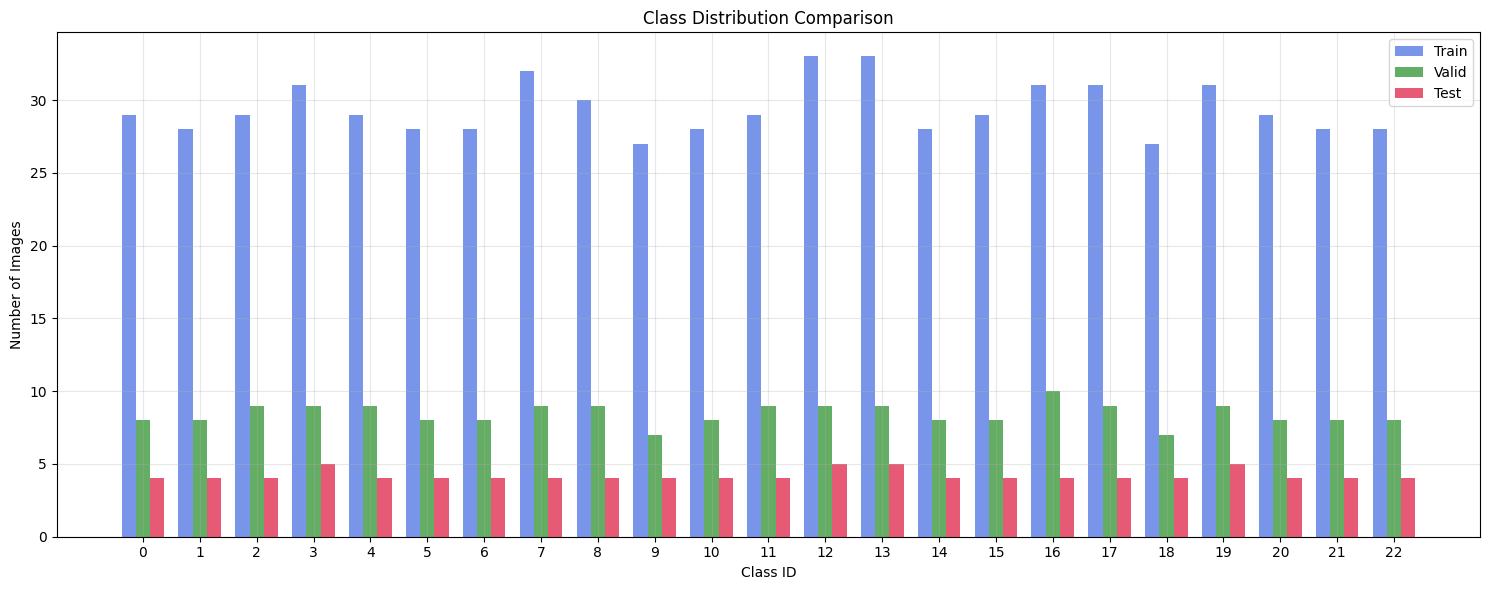

In [20]:
import os
import shutil
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def create_split_directories():
    for split in ['train', 'valid', 'test']:
        for subdir in ['images', 'labels']:
            path = os.path.join(f'{split}_split', subdir)
            if os.path.exists(path):
                shutil.rmtree(path)
            os.makedirs(path)

def get_dataset_info(image_dir, label_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    labels = []
    valid_files = []

    for img_file in image_files:
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.readline().split()[0])
                labels.append(label)
                valid_files.append(img_file)

    return valid_files, labels

def balanced_split(files, labels):
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        files, labels, train_size=0.7, stratify=labels, random_state=42
    )

    valid_files, test_files, valid_labels, test_labels = train_test_split(
        temp_files, temp_labels, train_size=0.67, stratify=temp_labels, random_state=42
    )

    return (train_files, train_labels), (valid_files, valid_labels), (test_files, test_labels)

def copy_files(files, labels, split_name, src_image_dir, src_label_dir):
    for file in files:
        src_img = os.path.join(src_image_dir, file)
        dst_img = os.path.join(f'{split_name}_split/images', file)
        shutil.copy2(src_img, dst_img)

        label_file = file.replace('.jpg', '.txt')
        src_label = os.path.join(src_label_dir, label_file)
        dst_label = os.path.join(f'{split_name}_split/labels', label_file)
        shutil.copy2(src_label, dst_label)

def visualize_distributions():
    plt.figure(figsize=(15, 6))

    # 각 분할 데이터셋의 클래스 분포 계산
    distributions = {}
    for split_name in ['train', 'valid', 'test']:
        label_dir = os.path.join(f'{split_name}_split/labels')
        class_counts = Counter()

        for label_file in os.listdir(label_dir):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                label = int(f.readline().split()[0])
                class_counts[label] += 1

        distributions[split_name] = class_counts

    # 모든 클래스 ID 추출
    all_classes = sorted(set().union(*[d.keys() for d in distributions.values()]))

    # 막대 그래프 그리기
    x = np.arange(len(all_classes))
    width = 0.25  # 막대 너비

    # 각 데이터셋별로 다른 색상 사용
    plt.bar(x - width, [distributions['train'].get(c, 0) for c in all_classes],
            width, label='Train', color='royalblue', alpha=0.7)
    plt.bar(x, [distributions['valid'].get(c, 0) for c in all_classes],
            width, label='Valid', color='forestgreen', alpha=0.7)
    plt.bar(x + width, [distributions['test'].get(c, 0) for c in all_classes],
            width, label='Test', color='crimson', alpha=0.7)

    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution Comparison')
    plt.xticks(x, all_classes)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    create_split_directories()

    image_dir = 'train/images'
    label_dir = 'train/labels'
    files, labels = get_dataset_info(image_dir, label_dir)

    train_data, valid_data, test_data = balanced_split(files, labels)

    copy_files(train_data[0], train_data[1], 'train', image_dir, label_dir)
    copy_files(valid_data[0], valid_data[1], 'valid', image_dir, label_dir)
    copy_files(test_data[0], test_data[1], 'test', image_dir, label_dir)

    visualize_distributions()

if __name__ == "__main__":
    main()


---

In [21]:
import albumentations as A
import cv2

def create_augmentation():
    transform = A.Compose([
        # 이미지를 90도 단위로 무작위 회전
        A.RandomRotate90(p=0.5),

        # 이미지를 수평 또는 수직으로 뒤집기
        A.Flip(p=0.5),

        # 이미지의 행과 열을 교환 (전치)
        A.Transpose(p=0.5),

        # 노이즈 추가 (둘 중 하나 선택)
        A.OneOf([
            # A.IAAAdditiveGaussianNoise(),  # 가우시안 노이즈 추가
            A.GaussNoise(),                # 일반적인 가우시안 노이즈
        ], p=0.2),

        # 블러 효과 (셋 중 하나 선택)
        A.OneOf([
            A.MotionBlur(p=0.2),          # 움직임 효과의 블러
            A.MedianBlur(blur_limit=3, p=0.1),  # 중간값 필터를 이용한 블러
            A.Blur(blur_limit=3, p=0.1),        # 일반적인 블러
        ], p=0.2),

        # 이미지 왜곡 (둘 중 하나 선택)
        A.OneOf([
            A.OpticalDistortion(p=0.3),    # 광학 왜곡 효과
            A.GridDistortion(p=0.1),       # 격자 형태의 왜곡
        ], p=0.2),

        # 이미지 선명도와 대비 조정 (셋 중 하나 선택)
        A.OneOf([
           # A.IAASharpen(),               # 이미지 선명도 증가
           # A.IAAEmboss(),                # 엠보싱 효과
            A.RandomBrightnessContrast(), # 밝기와 대비 무작위 조정
        ], p=0.3),

        # 색조, 채도, 명도 조정
        # A.HueSaturationValue(p=0.3),
    ])
    return transform

def augment_dataset(image_dir, label_dir, num_aug_per_image=2):
    transform = create_augmentation()

    # 이미지와 라벨 파일 목록
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    for img_file in image_files:
        # 이미지 로드
        image_path = os.path.join(image_dir, img_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 라벨 파일 경로
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        for i in range(num_aug_per_image):
            # 데이터 증강 적용
            augmented = transform(image=image)
            aug_image = augmented['image']

            # 증강된 이미지 저장
            aug_filename = f"{os.path.splitext(img_file)[0]}_aug{i}.jpg"
            aug_image_path = os.path.join(image_dir, aug_filename)
            aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(aug_image_path, aug_image)

            # 라벨 파일 복사
            aug_label_file = f"{os.path.splitext(img_file)[0]}_aug{i}.txt"
            aug_label_path = os.path.join(label_dir, aug_label_file)
            shutil.copy2(label_path, aug_label_path)

# 실행
image_dir = 'train_split/images'
label_dir = 'train_split/labels'
augment_dataset(image_dir, label_dir, num_aug_per_image=2)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-21-76ab5b13d80c>:10: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


In [22]:
def count_images_by_class(label_dir):
    # 클래스별 이미지 카운트
    class_counts = Counter()

    # 라벨 파일 읽기
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    # 전체 이미지 수
    total_images = sum(class_counts.values())

    print(f"전체 이미지 수: {total_images}")
    print("\n클래스별 이미지 수:")
    for class_id, count in sorted(class_counts.items()):
        print(f"Class {class_id}: {count} images")

    return class_counts

# 실행
label_dir = 'train_split/labels'
class_counts = count_images_by_class(label_dir)

전체 이미지 수: 2028

클래스별 이미지 수:
Class 0: 87 images
Class 1: 84 images
Class 2: 87 images
Class 3: 93 images
Class 4: 87 images
Class 5: 84 images
Class 6: 84 images
Class 7: 96 images
Class 8: 90 images
Class 9: 81 images
Class 10: 84 images
Class 11: 87 images
Class 12: 99 images
Class 13: 99 images
Class 14: 84 images
Class 15: 87 images
Class 16: 93 images
Class 17: 93 images
Class 18: 81 images
Class 19: 93 images
Class 20: 87 images
Class 21: 84 images
Class 22: 84 images


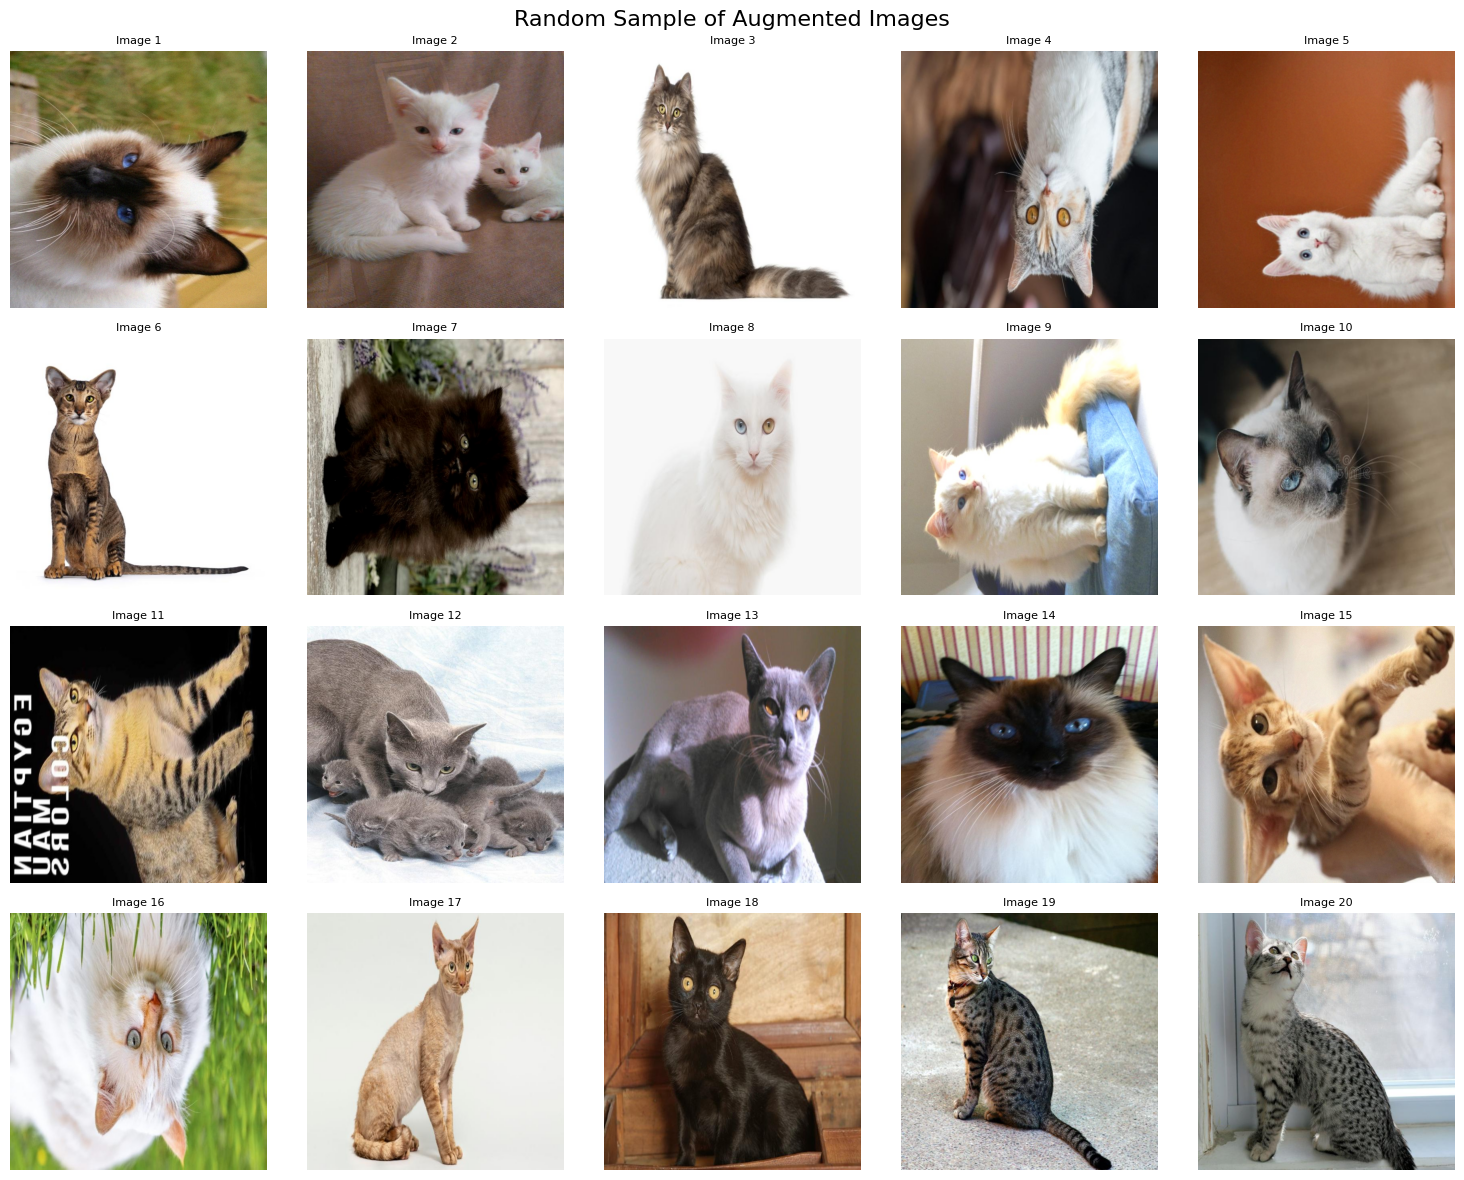

In [23]:
def plot_random_images(image_dir, num_images=20, seed=1):
    # 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # 이미지 파일 목록
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

    # 랜덤 선택
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    # 플롯 설정
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random Sample of Augmented Images', fontsize=16)

    for idx, img_file in enumerate(selected_files):
        # 이미지 로드
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 서브플롯에 이미지 표시
        row = idx // 5
        col = idx % 5
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {idx+1}', fontsize=8)

    plt.tight_layout()
    plt.show()

# 실행
image_dir = 'train_split/images'
plot_random_images(image_dir, num_images=20, seed=42)


---

# 학습

In [24]:
project = "./runs/detect"
name = "train_split"

dataset_path = "/content/data.yaml"

In [25]:
torch.cuda.empty_cache()

In [26]:
# YAML 파일 읽기
with open('data.yaml', 'r', encoding='utf-8') as file:
    data = yaml.safe_load(file)

# 경로 수정
data['train'] = '../train_split/images'
data['val'] = '../valid_split/images'
data['test'] = '../test_split/images'

# 수정된 YAML 파일 저장
with open('data.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(data, file, allow_unicode=True, sort_keys=False)

In [27]:
model.train(
    data=dataset_path, # 데이터셋 경로(yaml파일)
    epochs=10, # 최대 학습 epoch
    project=project, # project 폴더 이름
    name=name, # experiment 폴더 이름
    exist_ok=False, # 덮어쓰기 여부
    seed=42, # 재현성을 위한 시드 설정
    optimizer='AdamW', # optimizer는 AdamW로 지정
    patience=5, # 30epoch동안 loss가 개선되지 않으면 종료
    batch=32, # 훈련 배치 사이즈는 32
    imgsz=32, # 이미지 사이즈는 640
)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/data.yaml, epochs=10, time=None, patience=5, batch=32, imgsz=20, save=True, save_period=-1, cache=False, device=None, workers=8, project=./runs/detect, name=train_split, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 18.8MB/s]


Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/train_split/labels... 2028 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2028/2028 [00:01<00:00, 1658.27it/s]

train: New cache created: /content/train_split/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid_split/labels... 194 images, 0 backgrounds, 0 corrupt: 100%|██████████| 194/194 [00:00<00:00, 1699.76it/s]

val: New cache created: /content/valid_split/labels.cache


Plotting labels to runs/detect/train_split/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs/detect/train_split
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.801      3.426      1.232         13         32: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        194        206      0.572      0.127     0.0158    0.00498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.699      2.658      1.202         12         32: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        194        206      0.896     0.0189     0.0449     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.608      2.574      1.175         12         32: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        194        206       0.83     0.0435     0.0113    0.00422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.623      2.529      1.179         13         32: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        194        206      0.408      0.223     0.0383     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.59       2.51      1.161         13         32: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        194        206      0.899     0.0501     0.0312     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.539      2.443      1.158         12         32: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        194        206      0.493      0.144     0.0661     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.533      2.405      1.148         17         32: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        194        206      0.777      0.104     0.0822     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.495      2.379       1.13         13         32: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        194        206      0.431      0.153     0.0551     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.486      2.343      1.123         13         32: 100%|██████████| 64/64 [00:25<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        194        206      0.758     0.0997     0.0899     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.458      2.328      1.112         15         32: 100%|██████████| 64/64 [00:25<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        194        206      0.401      0.317     0.0834      0.043



10 epochs completed in 0.083 hours.
Optimizer stripped from runs/detect/train_split/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train_split/weights/best.pt, 5.4MB

Validating runs/detect/train_split/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


                   all        194        206      0.757     0.0997     0.0907     0.0481
            Abyssinian          8          8     0.0136       0.25     0.0206    0.00893
                Bengal          8          8      0.633      0.224      0.212      0.138
                Birman          9          9          1          0     0.0755     0.0485
                Bombay          9          9      0.474      0.444      0.521      0.317
          British Long          9         12          1          0     0.0272     0.0119
         British short          8          9          1          0     0.0432     0.0175
               Burmese          8          9          1          0      0.019    0.00924
              Domestic          9          9          1          0     0.0138    0.00596
          Egyption Mau          9         12          1          0     0.0168    0.00693
      Exotic Shorthair          7          7          1          0      0.238     0.0783
            Maine Coo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb1e4791420>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.0420

In [28]:
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 23
{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Long', 5: 'British short', 6: 'Burmese', 7: 'Domestic', 8: 'Egyption Mau', 9: 'Exotic Shorthair', 10: 'Maine Coon', 11: 'Munckin', 12: 'Norwegian Forest', 13: 'Oriental', 14: 'Persian', 15: 'Ragdoll', 16: 'Rex Type', 17: 'Russian Blue', 18: 'Scottish Fold', 19: 'Siamese Type', 20: 'Siberian', 21: 'Sphynx', 22: 'Turkish Angora'}


# 학습 시 Loss 및 성능 지표 변화 시각화

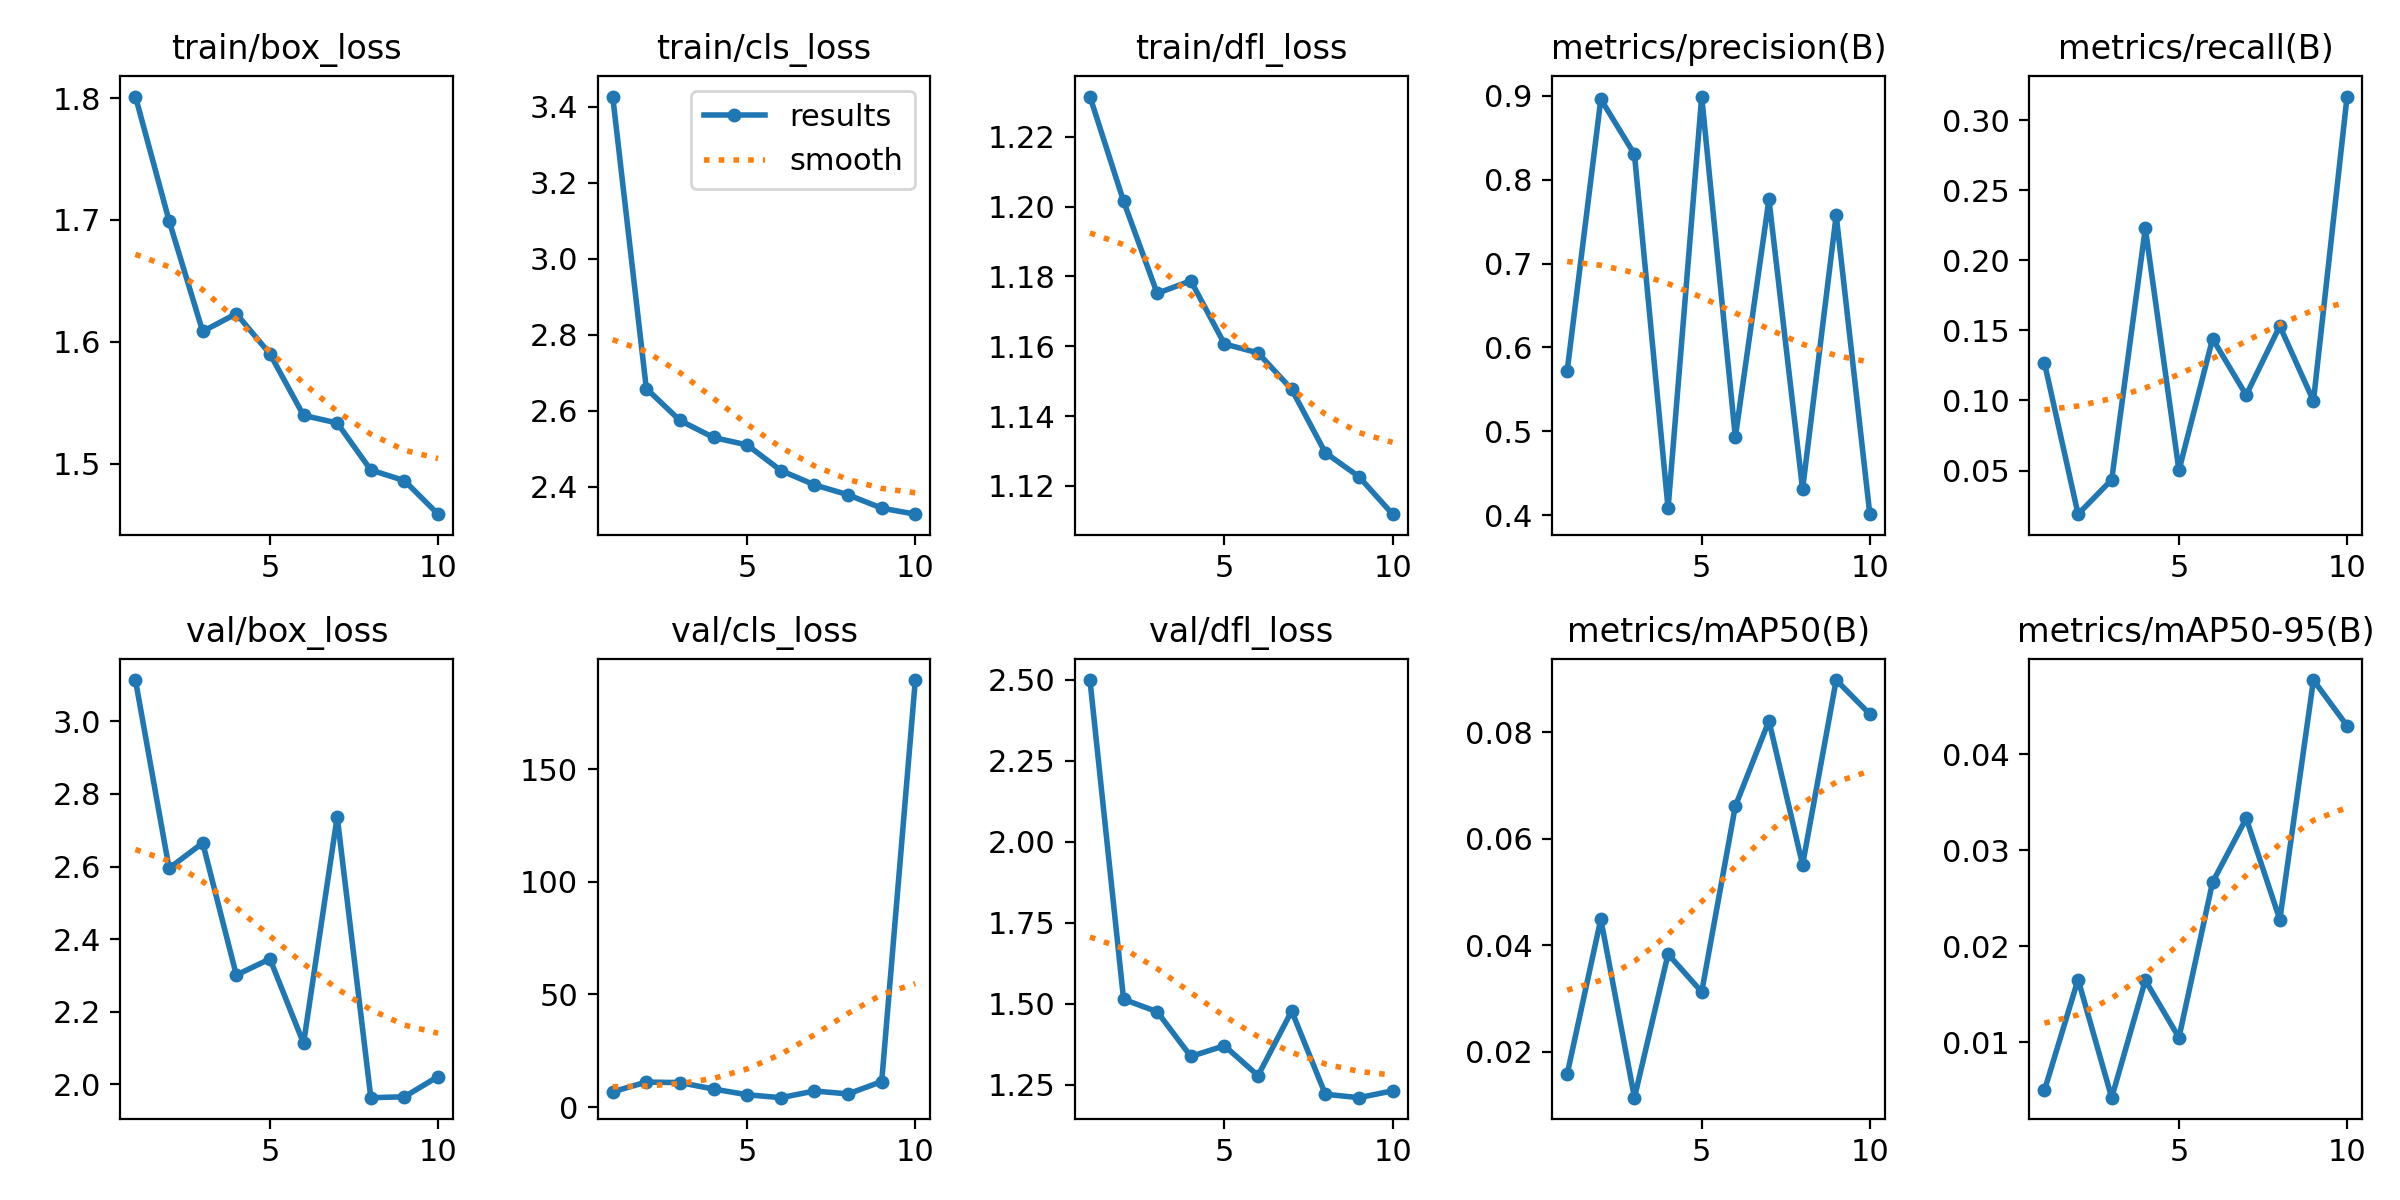

In [29]:
results_png_path = f"/content/runs/detect/train_split/results.png"  # Construct the expected path
show_image(results_png_path, width=1600)

In [30]:
model = YOLO(f"{project}/{name}/weights/best.pt")
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 23
{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Long', 5: 'British short', 6: 'Burmese', 7: 'Domestic', 8: 'Egyption Mau', 9: 'Exotic Shorthair', 10: 'Maine Coon', 11: 'Munckin', 12: 'Norwegian Forest', 13: 'Oriental', 14: 'Persian', 15: 'Ragdoll', 16: 'Rex Type', 17: 'Russian Blue', 18: 'Scottish Fold', 19: 'Siamese Type', 20: 'Siberian', 21: 'Sphynx', 22: 'Turkish Angora'}


In [31]:
test_name = "test_result" # 테스트 결과를 저장할 폴더 이름 설정
test_result = model.val(imgsz=640, split="test", name=test_name) # 테스트 데이터셋 평가 실행

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/test_split/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 1708.64it/s]

val: New cache created: /content/test_split/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 1/6 [00:10<00:54, 10.83s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 2/6 [00:19<00:39,  9.83s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:30<00:30, 10.23s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 4/6 [00:41<00:21, 10.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 5/6 [00:49<00:09,  9.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:00<00:00, 10.01s/it]


                   all         96        107      0.218    0.00621   7.93e-05   3.17e-05
            Abyssinian          4          7    0.00355      0.143    0.00182   0.000729
                Bengal          4          4          1          0          0          0
                Birman          4          4          0          0          0          0
                Bombay          5          5          1          0          0          0
          British Long          4          4          0          0          0          0
         British short          4          4          0          0          0          0
               Burmese          4          5          0          0          0          0
              Domestic          4          4          0          0          0          0
          Egyption Mau          4          8          0          0          0          0
      Exotic Shorthair          4          4          0          0          0          0
            Maine Coo

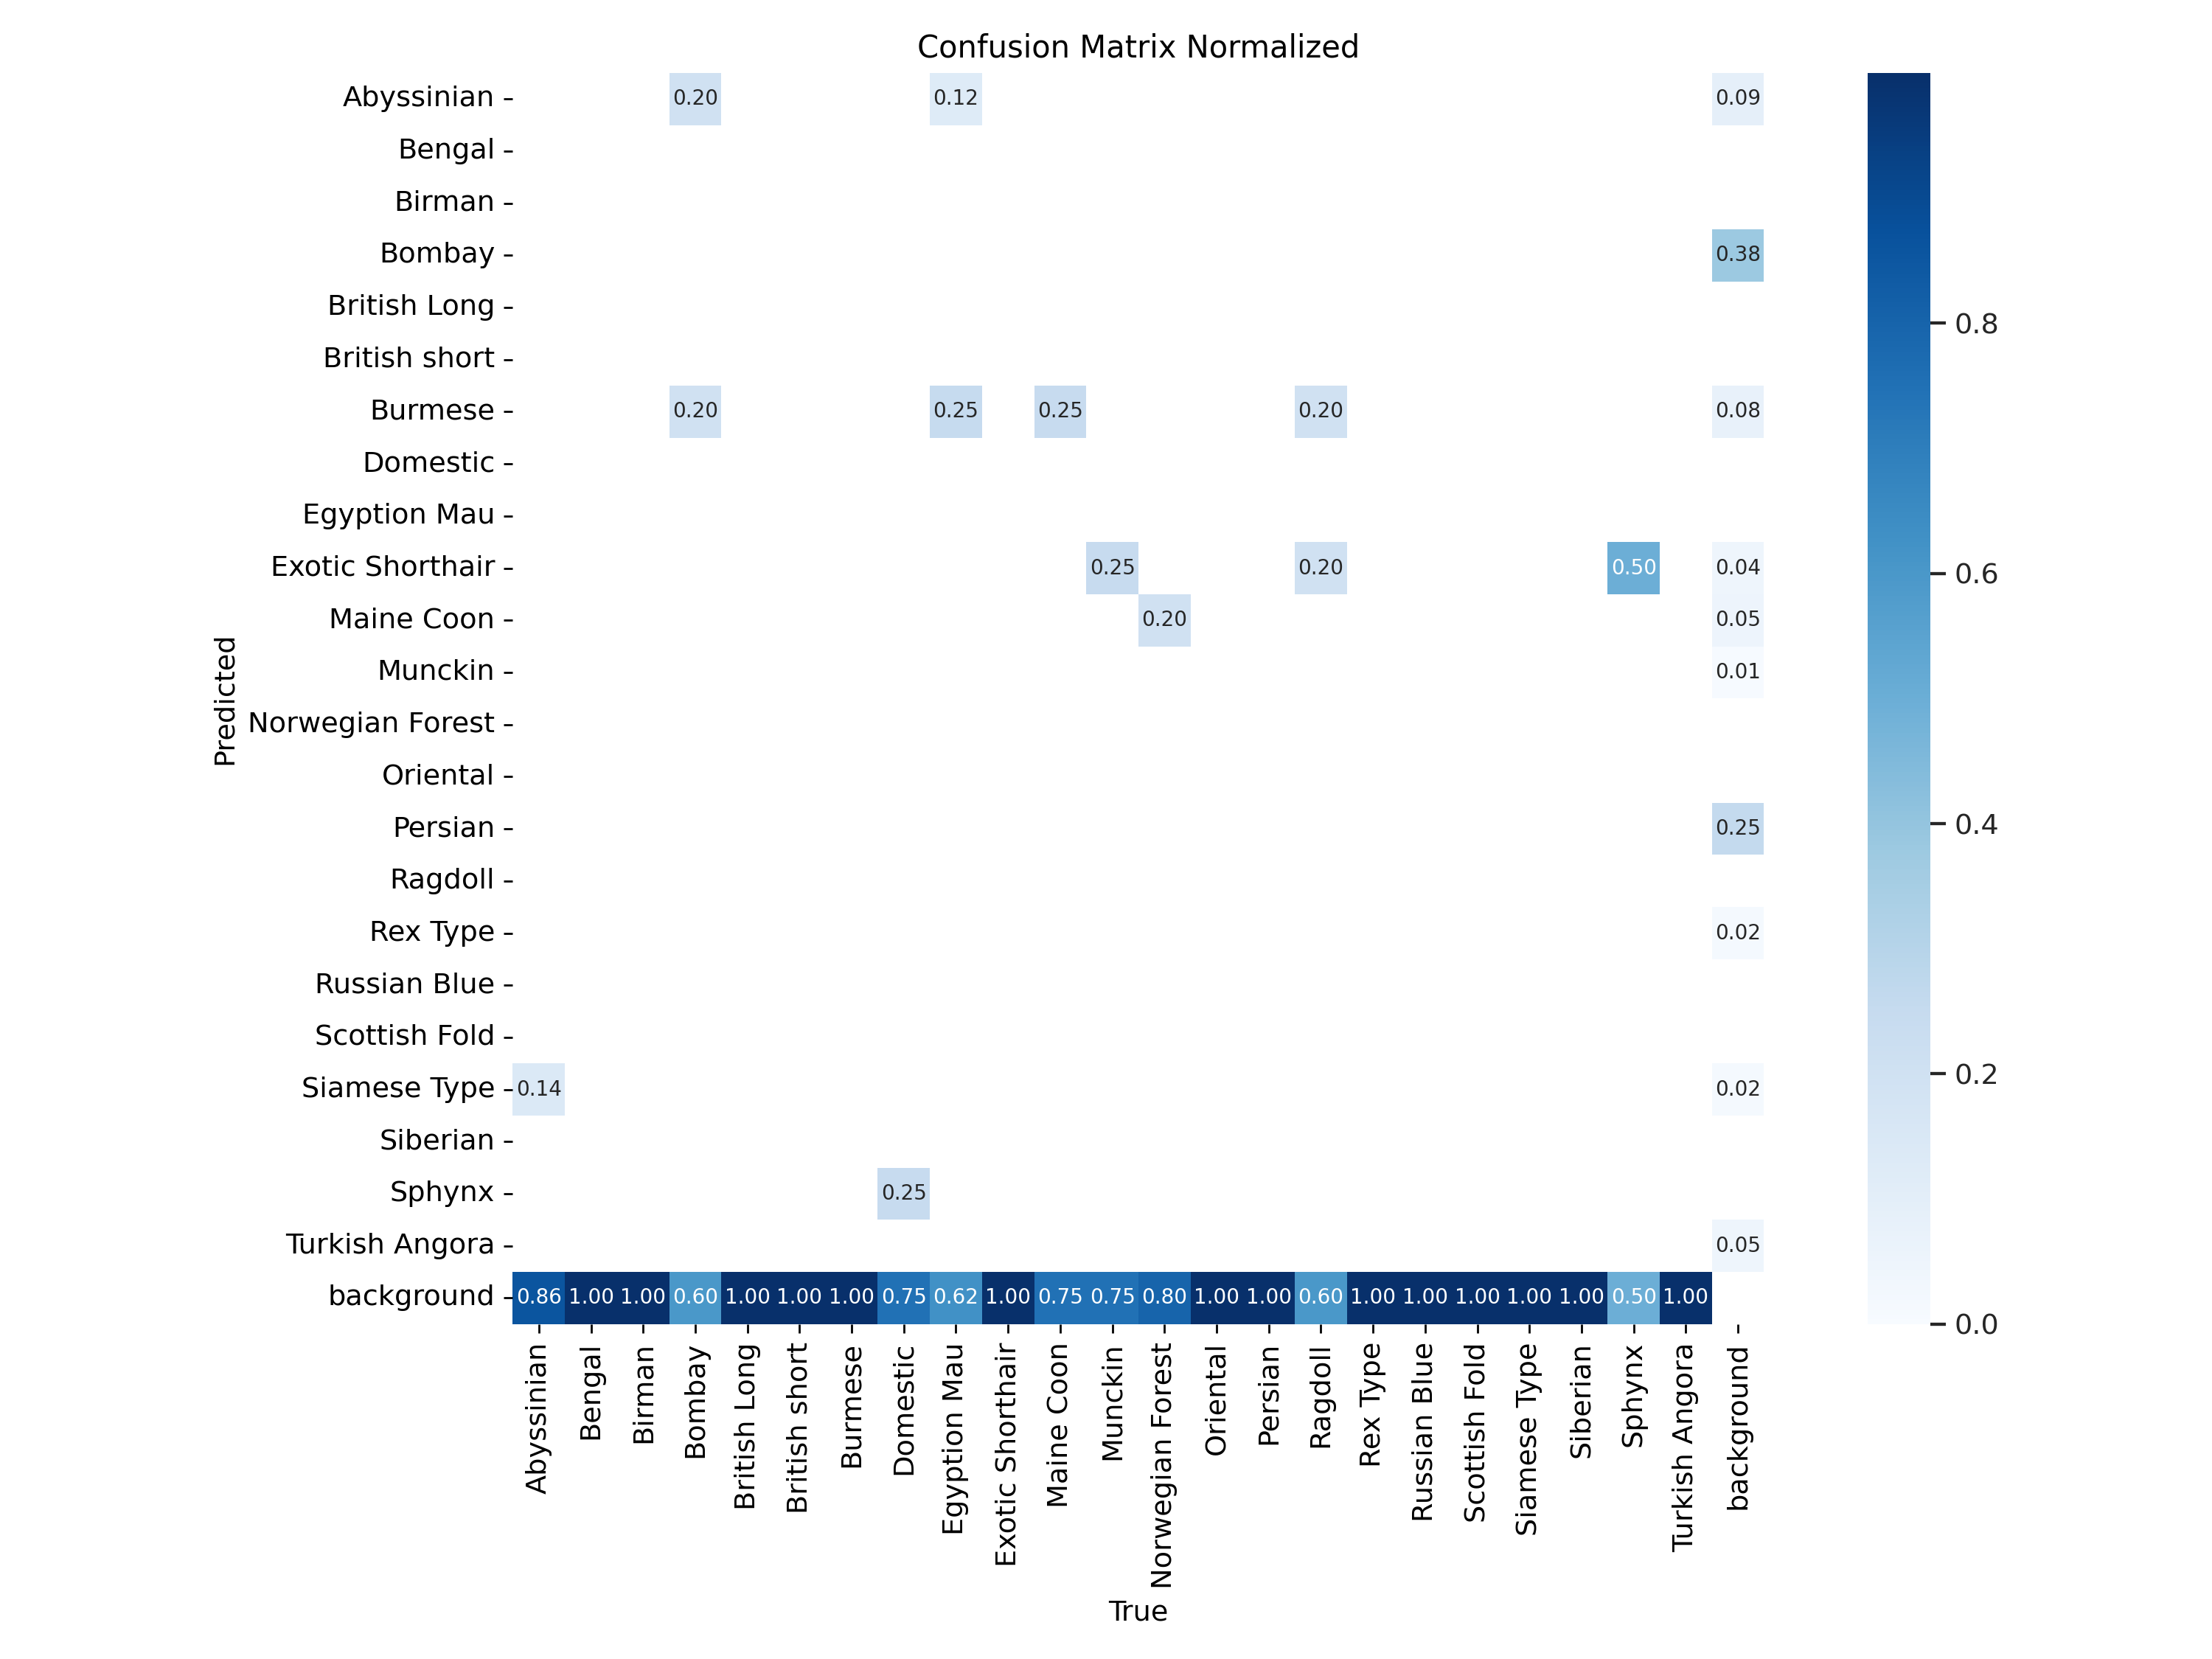

In [32]:
# 테스트 데이터셋 결과를 혼동 행렬 이미지로 시각화
show_image(f"runs/detect/test_result/confusion_matrix_normalized.png", width=800, height=800)

# 추론

In [35]:
# 이미지 경로 설정
image_path = "/content/test_split/images/*.jpg"

# 추론 실행
results = model.predict(source=image_path, save=True)

# 결과 출력
results


image 1/96 /content/test_split/images/Abyssinian_16_jpg.rf.178a71b30d179d02a1f55bbd5ed5179e.jpg: 32x32 (no detections), 22.9ms
image 2/96 /content/test_split/images/Abyssinian_25_jpg.rf.dbfb5d277883f927f5bbaa9e9339e4d6.jpg: 32x32 (no detections), 14.7ms
image 3/96 /content/test_split/images/Abyssinian_30_jpg.rf.2e6b296c63c3028d80028cb253473df2.jpg: 32x32 (no detections), 14.6ms
image 4/96 /content/test_split/images/Abyssinian_31_jpg.rf.beb3ca0dcfea7cc2024ddc7daef22139.jpg: 32x32 (no detections), 16.6ms
image 5/96 /content/test_split/images/American-Shorthair_45_jpg.rf.189e9ab24ab29de7f6987cea199dd4a4.jpg: 32x32 (no detections), 14.7ms
image 6/96 /content/test_split/images/American-Shorthair_8_jpg.rf.b448d6cfe571cdbcfed22dcb0b6dfc96.jpg: 32x32 1 Bombay, 23.2ms
image 7/96 /content/test_split/images/American-Wirehair_11_jpg.rf.c2f0fa9df3627a51c3c0d32620ed5c4f.jpg: 32x32 1 Bombay, 15.9ms
image 8/96 /content/test_split/images/American-Wirehair_12_jpg.rf.2fff72032017f81bc0bb76319751e2eb.jpg

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Long', 5: 'British short', 6: 'Burmese', 7: 'Domestic', 8: 'Egyption Mau', 9: 'Exotic Shorthair', 10: 'Maine Coon', 11: 'Munckin', 12: 'Norwegian Forest', 13: 'Oriental', 14: 'Persian', 15: 'Ragdoll', 16: 'Rex Type', 17: 'Russian Blue', 18: 'Scottish Fold', 19: 'Siamese Type', 20: 'Siberian', 21: 'Sphynx', 22: 'Turkish Angora'}
 obb: None
 orig_img: array([[[ 42,  33,  20],
         [ 42,  33,  20],
         [ 42,  33,  20],
         ...,
         [ 10,  10,  10],
         [ 11,  11,  11],
         [ 11,  11,  11]],
 
        [[ 42,  33,  20],
         [ 42,  33,  20],
         [ 42,  33,  20],
         ...,
         [ 10,  10,  10],
         [ 11,  11,  11],
         [ 11,  11,  11]],
 
        [[ 42,  33,  20],
         [ 42,  33,  20],
         [ 42,  33,  20],
        

In [36]:
def compute_each_label_accuracy(label_path, results):
    correct_pred = 0
    total_labels = 0

    # 결과에서 예측된 클래스와 신뢰도 추출
    predictions = {}
    for r in results:
        img_name = os.path.basename(r.path)
        label_name = img_name.replace('.jpg', '.txt')
        if len(r.boxes.cls) > 0:
            predictions[label_name] = int(r.boxes.cls[0])

    # 실제 라벨과 비교
    for label_file in os.listdir(label_path):
        total_labels += 1
        with open(os.path.join(label_path, label_file), 'r') as f:
            true_label = int(f.readline().split()[0])

        if label_file in predictions and predictions[label_file] == true_label:
            correct_pred += 1

    accuracy = correct_pred / total_labels if total_labels > 0 else 0
    return accuracy, total_labels, correct_pred

# 이미지 경로 설정
image_path = "/content/test_split/images/*.jpg"

# 추론 실행
results = model.predict(source=image_path, save=True)

# 정확도 계산
test_label_path = '/content/test_split/labels'
test_pred_label_accuracy, test_total_label, test_correct_label = compute_each_label_accuracy(test_label_path, results)

# 결과 출력
print(f"Accuracy: {test_pred_label_accuracy*100:.4f}%")
print(f"Total Labels: {test_total_label}")
print(f"Correctly Predicted Labels: {test_correct_label}")


image 1/96 /content/test_split/images/Abyssinian_16_jpg.rf.178a71b30d179d02a1f55bbd5ed5179e.jpg: 32x32 (no detections), 16.2ms
image 2/96 /content/test_split/images/Abyssinian_25_jpg.rf.dbfb5d277883f927f5bbaa9e9339e4d6.jpg: 32x32 (no detections), 12.2ms
image 3/96 /content/test_split/images/Abyssinian_30_jpg.rf.2e6b296c63c3028d80028cb253473df2.jpg: 32x32 (no detections), 10.7ms
image 4/96 /content/test_split/images/Abyssinian_31_jpg.rf.beb3ca0dcfea7cc2024ddc7daef22139.jpg: 32x32 (no detections), 10.4ms
image 5/96 /content/test_split/images/American-Shorthair_45_jpg.rf.189e9ab24ab29de7f6987cea199dd4a4.jpg: 32x32 (no detections), 11.7ms
image 6/96 /content/test_split/images/American-Shorthair_8_jpg.rf.b448d6cfe571cdbcfed22dcb0b6dfc96.jpg: 32x32 1 Bombay, 10.5ms
image 7/96 /content/test_split/images/American-Wirehair_11_jpg.rf.c2f0fa9df3627a51c3c0d32620ed5c4f.jpg: 32x32 1 Bombay, 14.2ms
image 8/96 /content/test_split/images/American-Wirehair_12_jpg.rf.2fff72032017f81bc0bb76319751e2eb.jpg

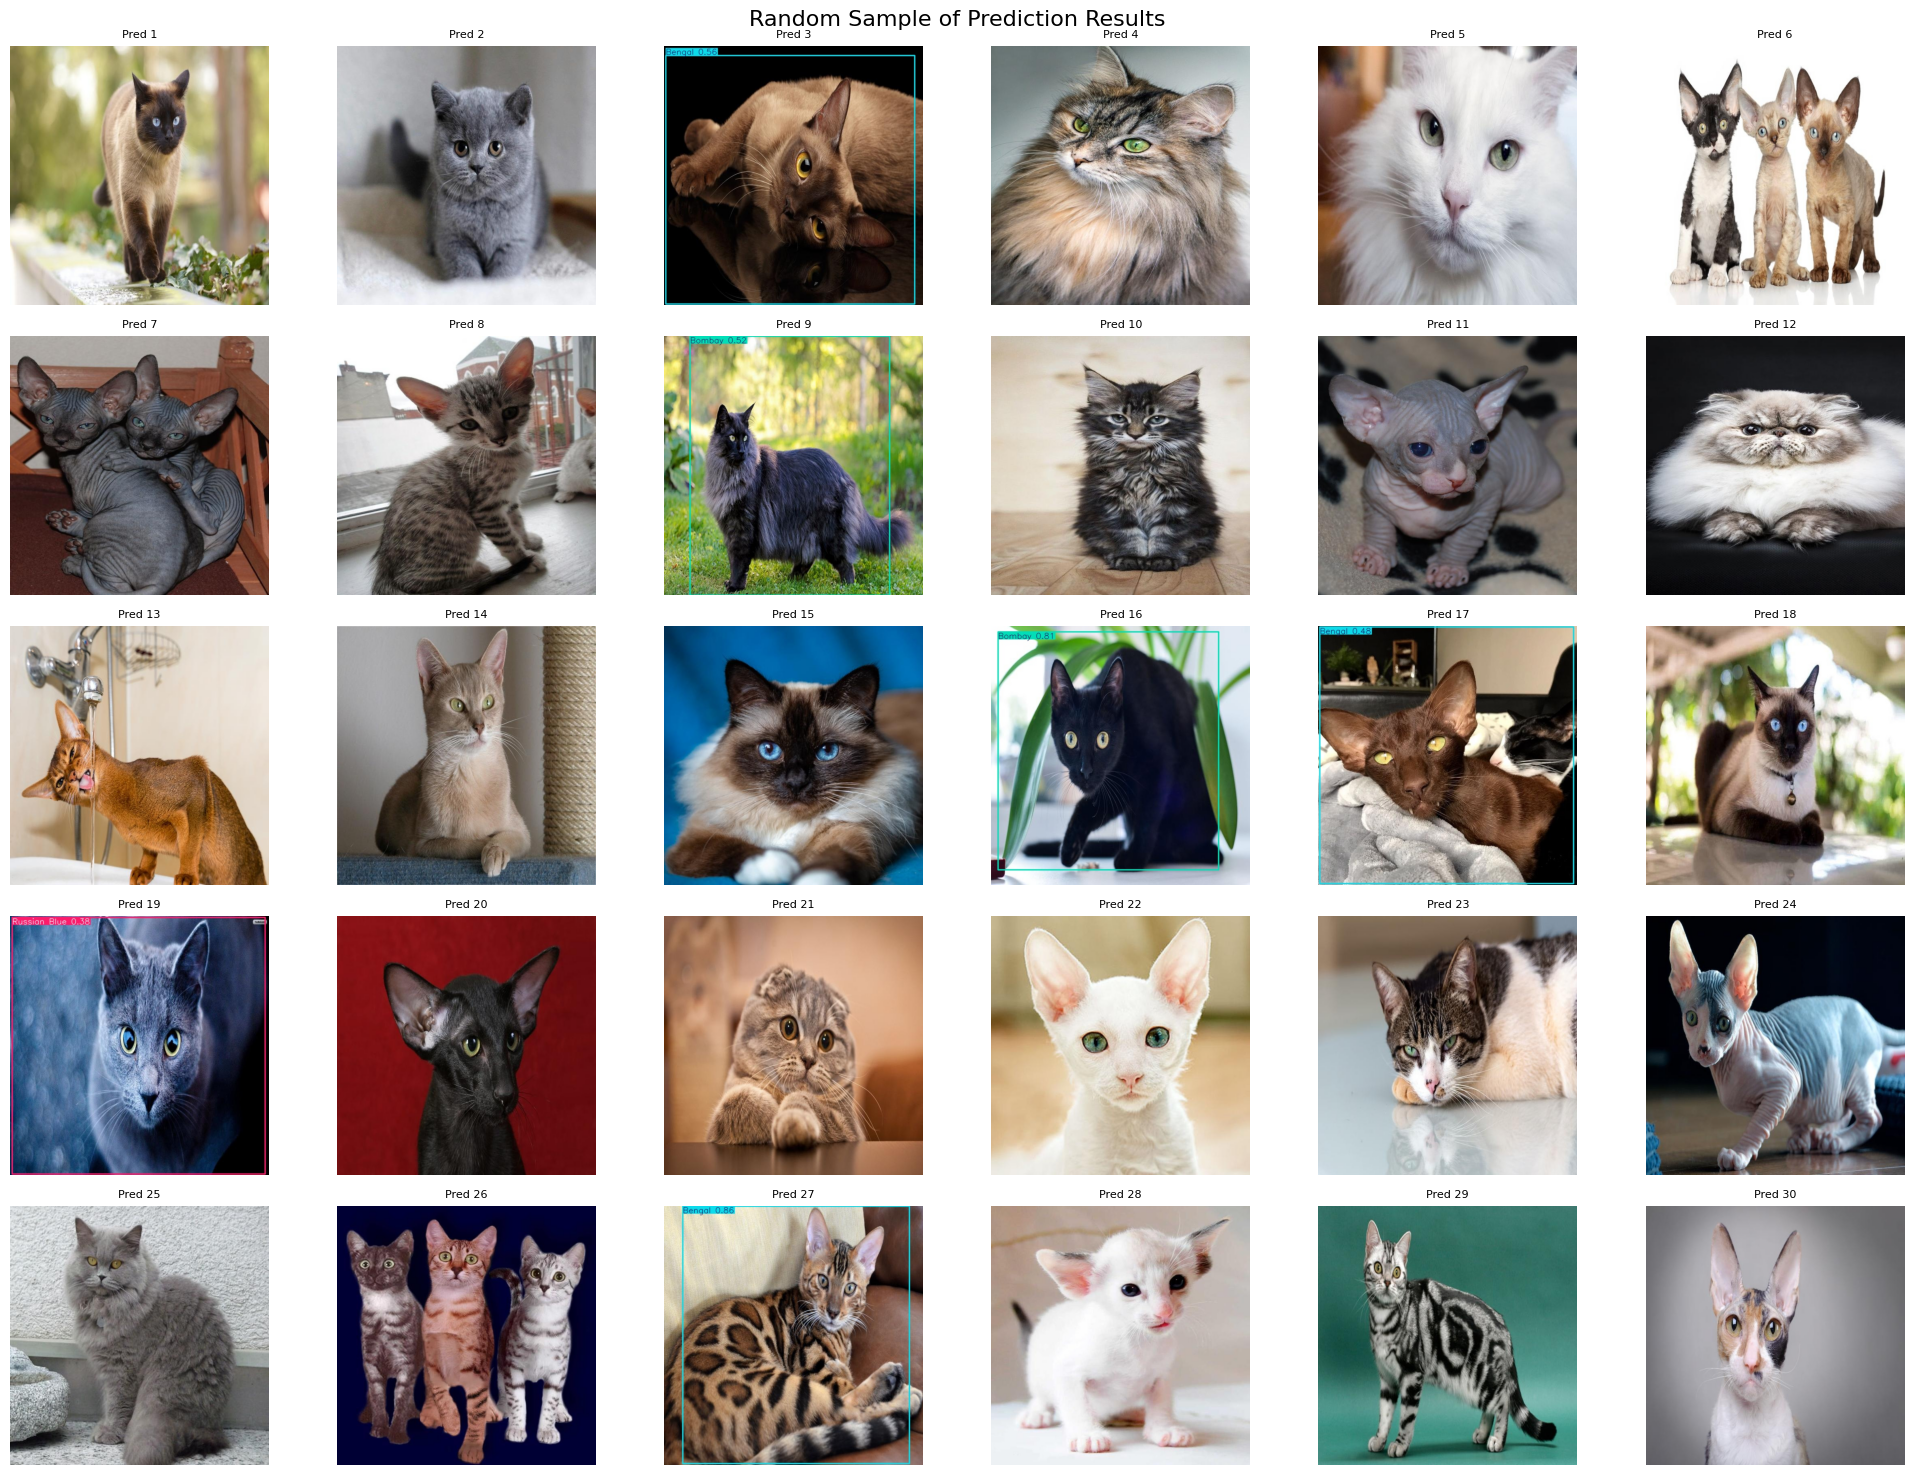

In [42]:
def plot_random_predictions(pred_dir, num_images=30, seed=42):
    # 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # 이미지 파일 목록
    image_files = [f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))]

    # 랜덤 선택
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    # 플롯 설정 (5x6 그리드)
    fig, axes = plt.subplots(5, 6, figsize=(20, 15))
    fig.suptitle('Random Sample of Prediction Results', fontsize=16)

    for idx, img_file in enumerate(selected_files):
        # 이미지 로드
        img_path = os.path.join(pred_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 서브플롯에 이미지 표시
        row = idx // 6
        col = idx % 6
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Pred {idx+1}', fontsize=8)

    plt.tight_layout()
    plt.show()

# 실행
pred_dir = '/content/runs/detect/predict'
plot_random_predictions(pred_dir, num_images=30, seed=42)


# zip 파일로 저장

In [ ]:
from google.colab import files

shutil.make_archive("runs", 'zip', "/content/runs")
files.download("runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>